In [429]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import phik
from phik.report import plot_correlation_matrix

# <b><u>Набор данных: german_used_cars:</u></b>

In [431]:
guc_df = pd.read_csv('german_used_cars.csv', index_col = 0)
guc_df.head()

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.00,2.0 V6 TB
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,NaN,- (g/km),190000.00,"Q4 Allrad, 3.2L GTA"
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,NaN,- (g/km),129000.00,ALFA ROME 916
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.00,2.0 16V Twin Spark L
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.00,"3.0i Super V6, absoluter Topzustand !"


Делаем копию дата-фрейма, чтобы не портить исходный:

In [433]:
guc_edt_df = guc_df.copy()

## <u>Обработаем полученный набор данных:<mu>

Столбeц offer_description не несет полезной информации. Его можно удалить:

In [436]:
guc_edt_df.drop('offer_description', axis = 1, inplace = True)

Смотрим параметры набора данных:

In [438]:
guc_edt_df.shape

(251079, 13)

In [439]:
guc_edt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251079 entries, 0 to 251078
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     251079 non-null  object 
 1   model                     251079 non-null  object 
 2   color                     250913 non-null  object 
 3   registration_date         251075 non-null  object 
 4   year                      251079 non-null  object 
 5   price_in_euro             251079 non-null  object 
 6   power_kw                  250945 non-null  object 
 7   power_ps                  250950 non-null  object 
 8   transmission_type         251079 non-null  object 
 9   fuel_type                 251079 non-null  object 
 10  fuel_consumption_l_100km  224206 non-null  object 
 11  fuel_consumption_g_km     251079 non-null  object 
 12  mileage_in_km             250927 non-null  float64
dtypes: float64(1), object(12)
memory usage: 26.8+ MB


<tr>Беглый просмотр структуры набора данных показал, что:
<li>- в некоторых строках столбцы не соответствуют своих позициям (например, в столбце year находится registration_date или transmission_type):</li>

In [441]:
guc_edt_df['year'].value_counts().tail()

year
05/2015     1
05/2016     1
07/2018     1
Electric    1
CNG         1
Name: count, dtype: int64

<li>- в некоторых столбцах присутствуют пустые значения:</li>

In [443]:
nan_values = guc_edt_df.isna().sum()
nan_values[nan_values.values != 0]

color                         166
registration_date               4
power_kw                      134
power_ps                      129
fuel_consumption_l_100km    26873
mileage_in_km                 152
dtype: int64

Чтобы повысить качество набора данных решил оставить только те строки, где данные во всех столбцах либо соответствуют формату, либо пустые.
<tr>Для этого завел словарь, где: 
<li>- в качестве ключа взял наименование столбца,</li>
<li>- в качестве значения список из 2х значений: 1) регулярное выражение с форматом; 2) тип, к которому необходимо привести значения столбца (либо пусто, если преобразования типа не требуется)</li>
</tr>

In [445]:
cols_dict = {
    'registration_date': ['^(0?[1-9]|1[012])/(199[0-9]|20[012][0-9])$', ''],
    'year': ['^(199[0-9]|20[012][0-9])$', ''],
    'price_in_euro': ['^(\d+(,|.)\d+|[1-9]\d*)$', 'float'],
    'power_kw': ['^(\d+(,|.)\d+|[1-9]\d*)$', 'float'],
    'power_ps': ['^(\d+(,|.)\d+|[1-9]\d*)$', 'float'],
    'fuel_type': ['^\w+$', ''],
    'fuel_consumption_l_100km': ['^(\d+(,|.)\d+|[1-9]\d*) l/100 km$', ''],
    'fuel_consumption_g_km': ['^(\d+(,|.)\d+|[1-9]\d*) g/km$', ''],
    'mileage_in_km': ['^(\d+(,|.)\d+|[1-9]\d*)$', '']
}

Добавил функцию для определения корректности значения:

In [447]:
def value_is_correct(value, pattern):
    '''
    Возвращает True для:
    - пустых значений;
    - подходящих под регулярное выражение
    '''
    if value != value: return True # Для пустых значений
    elif re.match(pattern, value): return True # Для значений в правильном формате
    else: return False # Для не пустых в не правильном формате

Добавил функцию, которая оставляет строки с форматными значениями в столбцах, согласно словарю выше:

In [449]:
def filter_rows(df, cols_dict):
    '''
    1. Фильтрует строки дата-фрейма по значению в столбце. Осталяет только те строки, где значение подходит под регулярное выражение;
    2. Тип данных в столбце преобразует к указанному.
    df - дата-фрейм;
    cols_dict - справочник, в котором:
    ключ - название столбца; 
    значение - список из регулярного выражения и типа для преобразования значений столбца (может быть пустым)
    '''
    for key, value in cols_dict.items():
        column = key
        pattern = value[0]
        type_ = value[1]
        try:
            df = df[df[column].apply(value_is_correct, args = (pattern,))]
        except:
            df = df[df[column].astype('str').apply(value_is_correct, args = (pattern,))]
        if type_ != '': df = df.astype({column: type_})
    return df

Пропускаем набор данных через функцию:

In [451]:
guc_edt_df = filter_rows(guc_edt_df, cols_dict)

Редактируем значения расхода топлива, чтобы можно было представить их в числовом формате:

In [453]:
guc_edt_df['fuel_consumption_l_100km'] = guc_edt_df['fuel_consumption_l_100km'].str.replace(' l/100 km', '').str.replace(',', '.').astype('float')
guc_edt_df['fuel_consumption_g_km'] = guc_edt_df['fuel_consumption_g_km'].str.replace(' g/km', '').str.replace(',', '.').astype('float')

Смотрим, что получилось:

In [455]:
guc_edt_df.shape

(200320, 13)

In [456]:
guc_edt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200320 entries, 0 to 251076
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     200320 non-null  object 
 1   model                     200320 non-null  object 
 2   color                     200172 non-null  object 
 3   registration_date         200320 non-null  object 
 4   year                      200320 non-null  object 
 5   price_in_euro             200320 non-null  float64
 6   power_kw                  200250 non-null  float64
 7   power_ps                  200250 non-null  float64
 8   transmission_type         200320 non-null  object 
 9   fuel_type                 200320 non-null  object 
 10  fuel_consumption_l_100km  198154 non-null  float64
 11  fuel_consumption_g_km     200320 non-null  float64
 12  mileage_in_km             200320 non-null  float64
dtypes: float64(6), object(7)
memory usage: 21.4+ MB


In [457]:
nan_values = guc_edt_df.isna().sum()
nan_values[nan_values.values != 0]

color                        148
power_kw                      70
power_ps                      70
fuel_consumption_l_100km    2166
dtype: int64

В итоге повысили качество данных в наборе путем удаления строк со значениями не в нужном формате. Объем данных не позволяет анализировать каждую из таких строк и как-то ее обрабатывать.

<tr>Из описания набора данных видно, что есть 2 группы взаимозависимых показателей:
<li>- мощность: power_kw и power_ps</li>
<li>- расход топлива: fuel_consumption_l_100km и fuel_consumption_g_km</li>
</tr>

## <i><u>Однофакторный анализ:</u></i>

Определим базовые статистики по столбцам с не прерывными значениями:

In [462]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
guc_edt_df.describe()

,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,200320.00,200250.00,200250.00,198154.00,200320.00,200320.00
mean,26110.16,124.41,169.23,6.05,146.11,81791.62
std,36155.21,69.95,95.07,2.63,46.36,75953.03
min,149.00,10.00,14.00,0.10,1.00,0.00
25%,12499.00,81.00,110.00,4.90,119.00,23245.00
50%,19990.00,110.00,150.00,5.70,137.00,65000.00
75%,29940.00,140.00,190.00,6.70,164.00,121000.00
max,5890500.00,735.00,999.00,173.00,999.00,3800000.00


<u>Построим графики по вычищенному набору:</u>

In [464]:
sns.set_theme()

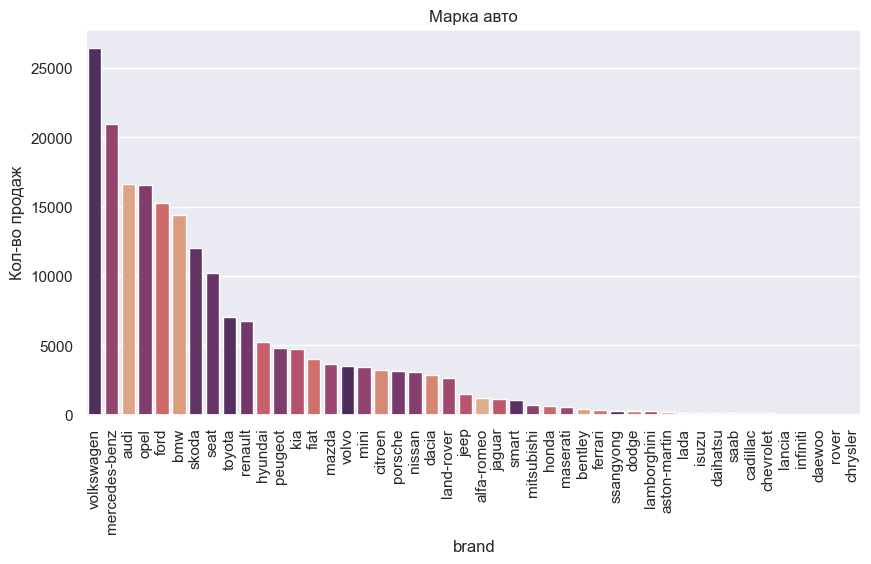

In [465]:
plt.figure(figsize = [10, 5])
plt.xticks(rotation = 90)
plt.title('Марка авто')
plt.ylabel('Кол-во продаж')
sns.countplot(data = guc_edt_df, x = 'brand', hue = 'brand', legend = False, order = guc_edt_df['brand'].value_counts().index, palette = 'flare')
plt.show()

По данному графику сложно сделать какие-то выводы.<br/>
Самая распространенная марка авто - Volkswagen

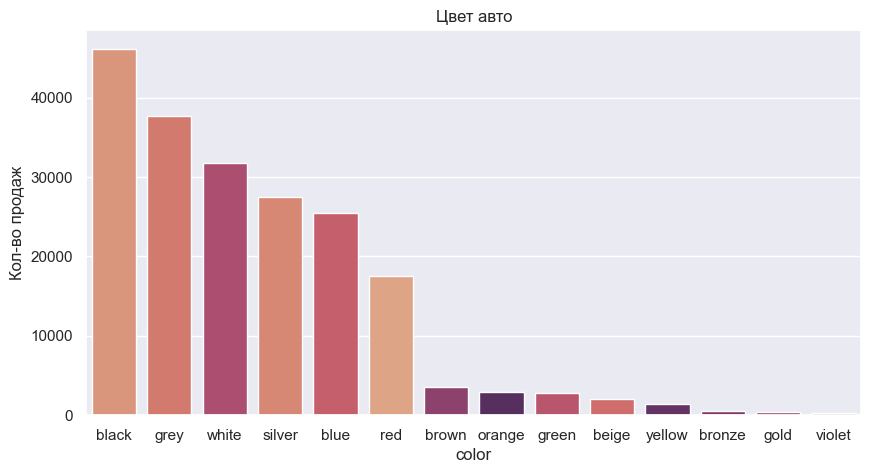

In [467]:
plt.figure(figsize = [10, 5])
plt.title('Цвет авто')
plt.ylabel('Кол-во продаж')
sns.countplot(data = guc_edt_df, x = 'color', hue = 'color', legend = False, order = guc_edt_df['color'].value_counts().index, palette = 'flare')
plt.show()

Самый распространеный цвет - черный

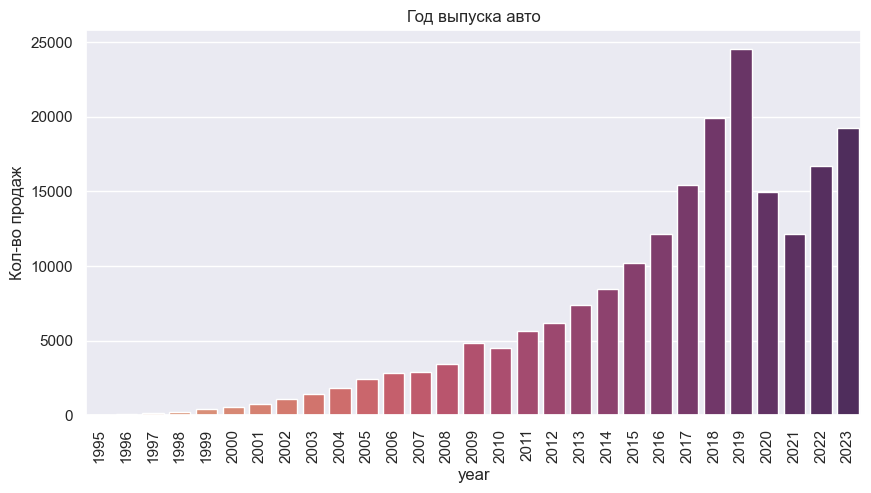

In [469]:
plt.figure(figsize = [10, 5])
plt.xticks(rotation = 90)
plt.title('Год выпуска авто')
plt.ylabel('Кол-во продаж')
sns.countplot(data = guc_edt_df, x = 'year', hue = 'year', legend = False, palette = 'flare')
plt.show()

С 1995 года наблюдался покупательский рост вплоть до 2019 года. После наблюдается замедление роста. Возможно, связано с началом пандемии

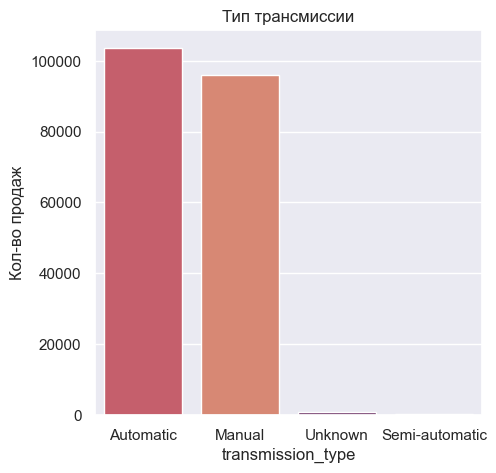

In [471]:
plt.figure(figsize = [5, 5])
plt.title('Тип трансмиссии')
plt.ylabel('Кол-во продаж')
sns.countplot(data = guc_edt_df, x = 'transmission_type', hue = 'transmission_type', legend = False, order = guc_edt_df['transmission_type'].value_counts().index, palette = 'flare')
plt.show()

Авто с механической и автоматической КПП приобретают приблизительно с одинаковой долей

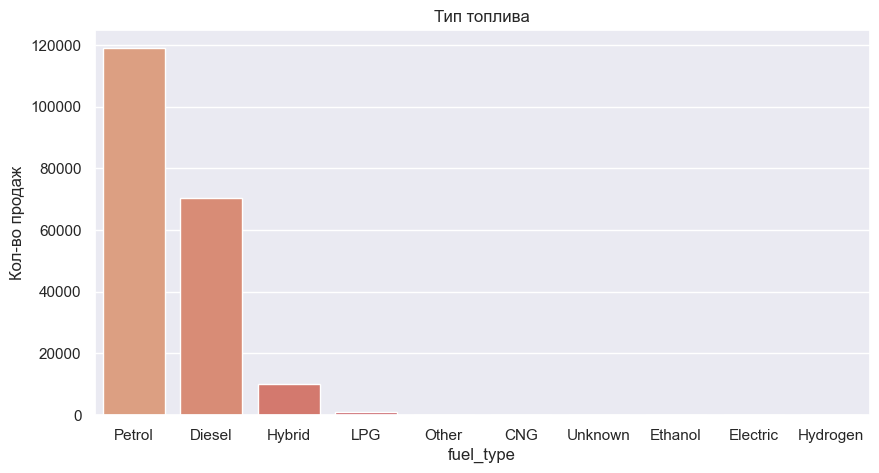

In [473]:
plt.figure(figsize = [10, 5])
plt.title('Тип топлива')
plt.ylabel('Кол-во продаж')
s = sns.countplot(data = guc_edt_df, x = 'fuel_type', hue = 'fuel_type',  legend = False, order = guc_edt_df['fuel_type'].value_counts().index, palette = 'flare')
plt.show()

Преобладают продажи бензиновых двигателей. Менее распространены дизельные и гибридные порядка. 70% от продаж бензиновых. 

### <u>Посмотрим на распределение данных:</u>

Для гистограмм попытался посчитать оптимальное кол-во значений для bins:

In [477]:
def count_bins(df, column, n):
    '''
    Функция считает оптимальное кол-во bins для гистограммы
    df - датафрейм;
    column - наименование колонки по оси X;
    n - кол-во наблюдений.
    '''
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    h = 2 * IQR * n**(-1./3)
    return (df[column].max() -df[column].min()) / h


In [478]:
print(f"price_in_euro - \t\t{count_bins(guc_edt_df, 'price_in_euro', 50):.0f} bins")
print(f"power_kw - \t\t\t{count_bins(guc_edt_df, 'power_kw', 50):.0f} bins")
print(f"power_ps - \t\t\t{count_bins(guc_edt_df, 'power_ps', 50):.0f} bins")
print(f"fuel_consumption_l_100km - \t{count_bins(guc_edt_df, 'fuel_consumption_l_100km', 50):.0f} bins")
print(f"fuel_consumption_g_km - \t{count_bins(guc_edt_df, 'fuel_consumption_g_km', 50):.0f} bins")
print(f"mileage_in_km - \t\t{count_bins(guc_edt_df, 'mileage_in_km', 50):.0f} bins")

price_in_euro - 		622 bins
power_kw - 			23 bins
power_ps - 			23 bins
fuel_consumption_l_100km - 	177 bins
fuel_consumption_g_km - 	41 bins
mileage_in_km - 		72 bins


Но построение графиков с рассчитанными значениями показал, что они не оптимальны.

Построим графики распределения продаж и посчитаем основные статистики для них:

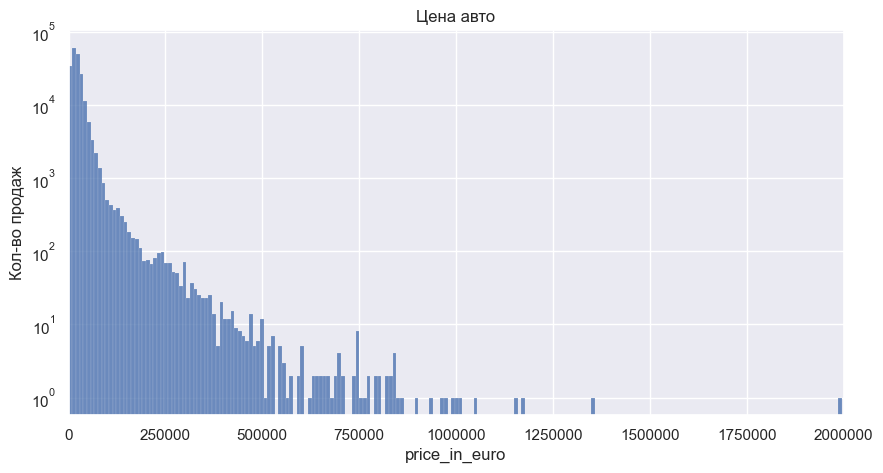

In [481]:
plt.figure(figsize = [10, 5])
plt.title('Цена авто')
plt.ylabel('Кол-во продаж')
plt.ticklabel_format(axis='x', style='plain')
s = sns.histplot(data = guc_edt_df, x = 'price_in_euro', bins = 620, alpha = 0.8)
s.set_yscale('log')
s.set_xlim(0, 2*10**6)
plt.show()

In [482]:
print(guc_edt_df.describe()['price_in_euro'])
print(f"\nМода = {guc_edt_df['price_in_euro'].mode()[0]}")

count    200320.00
mean      26110.16
std       36155.21
min         149.00
25%       12499.00
50%       19990.00
75%       29940.00
max     5890500.00
Name: price_in_euro, dtype: float64

Мода = 19990.0


Видно, что преобладают продажи машин из дешевого сегмента. С ростом цены продажи падают по экспоненте. После 1 млн. евро видны единичные продажи, которые можно считать выбросами в данных. Самый распространенный ценовой сегмент лежит в районе 20000 евро.

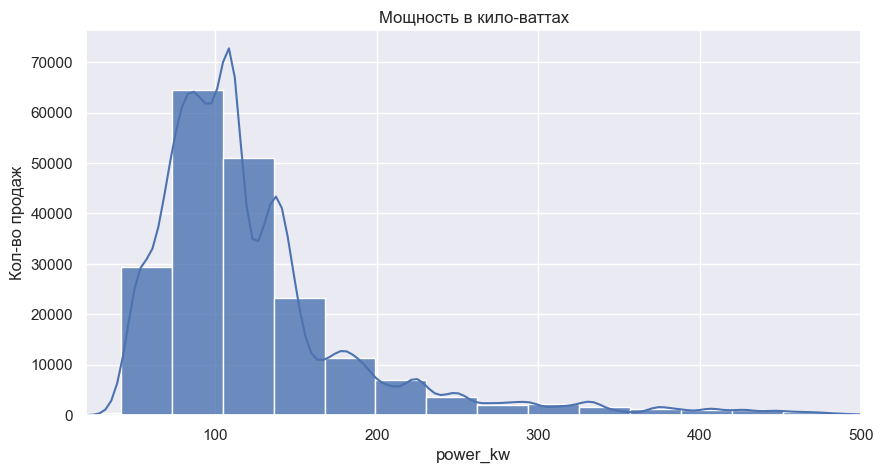

In [484]:
plt.figure(figsize = [10, 5])
plt.title('Мощность в кило-ваттах')
plt.ylabel('Кол-во продаж')
s = sns.histplot(data = guc_edt_df, x = 'power_kw', bins = 23, kde = True, alpha = 0.8)
s.set_xlim(20, 500)
plt.show()

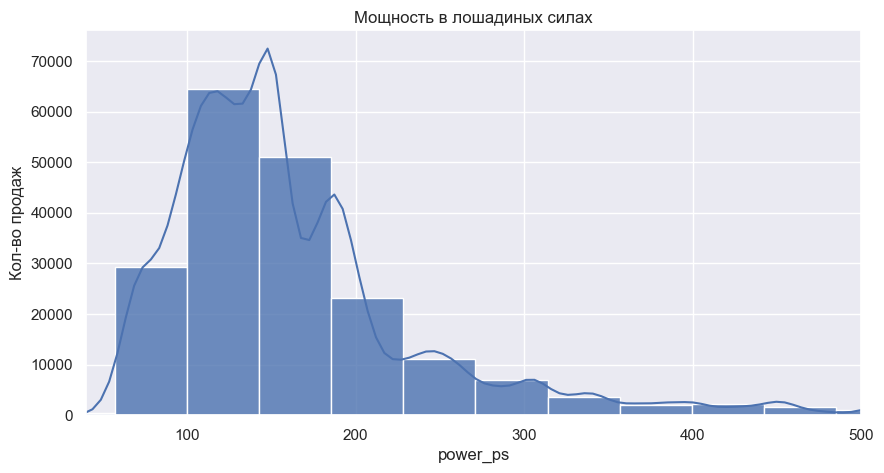

In [485]:
plt.figure(figsize = [10, 5])
plt.title('Мощность в лошадиных силах')
plt.ylabel('Кол-во продаж')
s = sns.histplot(data = guc_edt_df, x = 'power_ps', bins = 23, kde = True, alpha = 0.8)
s.set_xlim(40, 500)
plt.show()

In [486]:
print(guc_edt_df.describe()['power_ps'])
print(f"\nМода = {guc_edt_df['power_ps'].mode()[0]}")

count   200250.00
mean       169.23
std         95.07
min         14.00
25%        110.00
50%        150.00
75%        190.00
max        999.00
Name: power_ps, dtype: float64

Мода = 150.0


Графики мощностей в кило-ваттах и лошадиных силах соотносятся друг с другом. Имеют нормальное распределение с центрами около 100 и 150 соответственно.<br/>
Самая распространенная мощность на рынке авто 150 л/с.

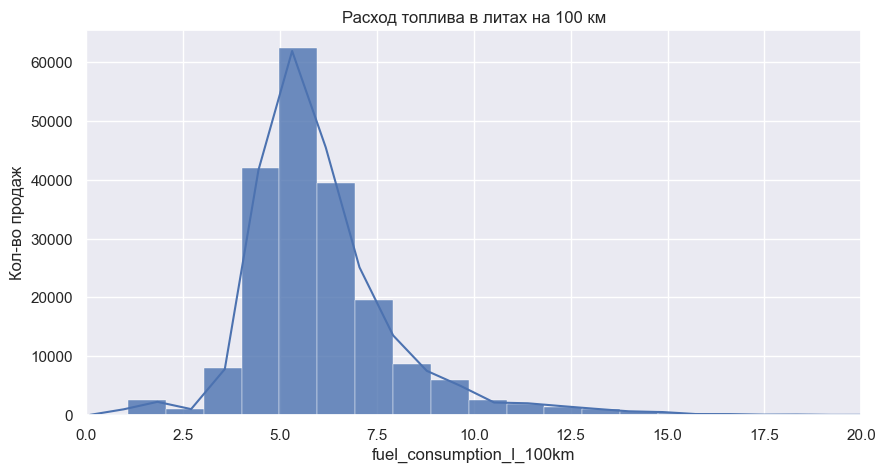

In [488]:
plt.figure(figsize = [10, 5])
plt.title('Расход топлива в литах на 100 км')
plt.ylabel('Кол-во продаж')
s = sns.histplot(data = guc_edt_df, x = 'fuel_consumption_l_100km', bins = 177, kde = True, alpha = 0.8)
s.set_xlim(0, 20)
plt.show()

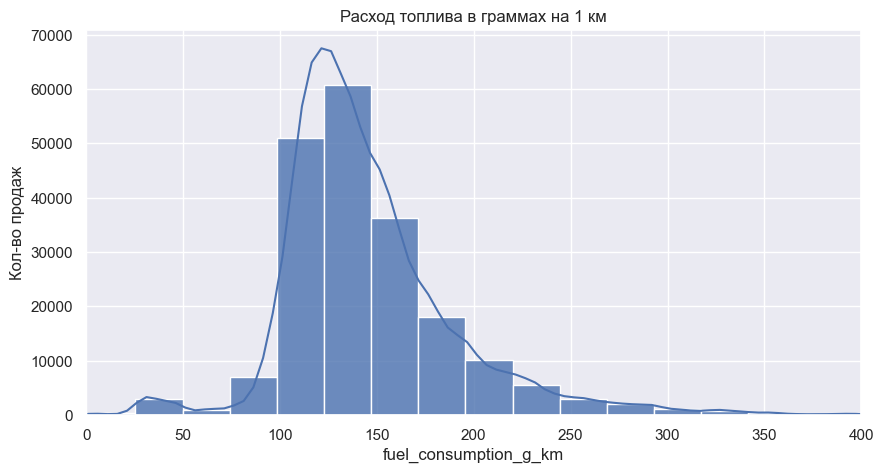

In [489]:
plt.figure(figsize = [10, 5])
plt.title('Расход топлива в граммах на 1 км')
plt.ylabel('Кол-во продаж')
s = sns.histplot(data = guc_edt_df, x = 'fuel_consumption_g_km', bins = 41, kde = True, alpha = 0.8)
s.set_xlim(0, 400)
plt.show()

In [490]:
print(guc_edt_df.describe()['fuel_consumption_g_km'])
print(f"\nМода = {guc_edt_df['fuel_consumption_g_km'].mode()[0]}")

count   200320.00
mean       146.11
std         46.36
min          1.00
25%        119.00
50%        137.00
75%        164.00
max        999.00
Name: fuel_consumption_g_km, dtype: float64

Мода = 119.0


Графики расхода топлива также соотносятся друг с другом. Имеют нормальное распределение с центрами около 5,5 л/100 км и 120 г/км соответственно.<br/>

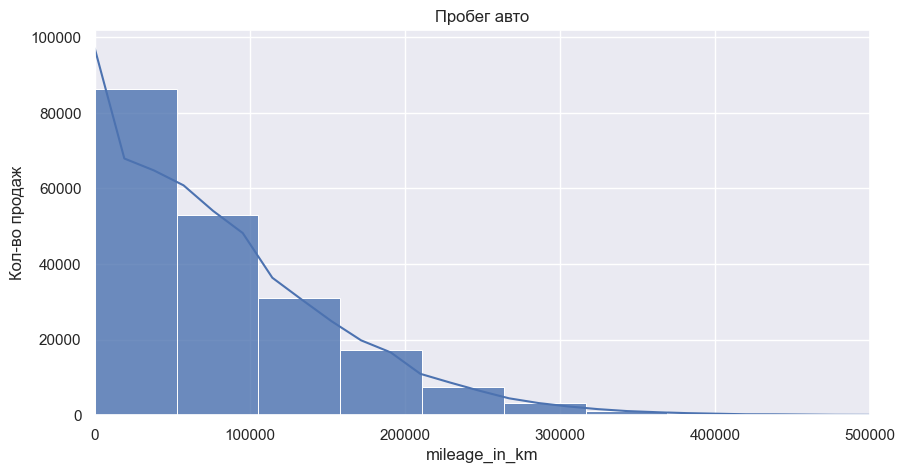

In [492]:
plt.figure(figsize = [10, 5])
plt.title('Пробег авто')
plt.ylabel('Кол-во продаж')
plt.ticklabel_format(axis='x', style='plain')
s = sns.histplot(data = guc_edt_df, x = 'mileage_in_km', bins = 72, kde = True, alpha = 0.8)
s.set_xlim(0, 0.5*10**6)
plt.show()

In [493]:
print(guc_edt_df.describe()['mileage_in_km'])
print(f"\nМода = {guc_edt_df['mileage_in_km'].mode()[0]}")

count    200320.00
mean      81791.62
std       75953.03
min           0.00
25%       23245.00
50%       65000.00
75%      121000.00
max     3800000.00
Name: mileage_in_km, dtype: float64

Мода = 10.0


С увеличением пробега кол-во продаж падает по экспоненте. Наиболее покупаемые машины с пробегом до 10 тыс.км. По сути, можно считать, что эти авто приобретаются, как новые, а пробег идет на доставку покупателю.

## <i><u>Двуфакторный анализ:</u></i>

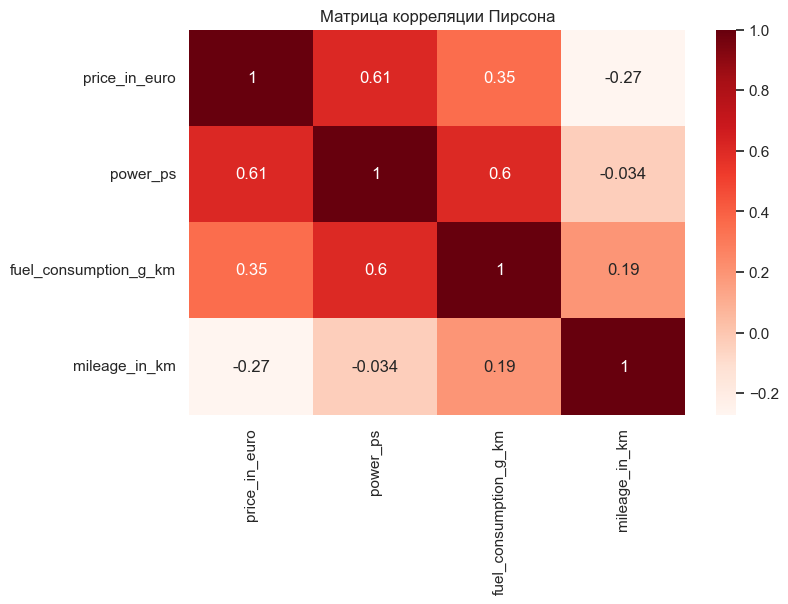

In [496]:
corr_matrix_pearson = guc_edt_df[['price_in_euro', 'power_ps', 'fuel_consumption_g_km', 'mileage_in_km']].corr()
plt.figure(figsize=[8,5])
sns.heatmap(corr_matrix_pearson, annot=True, cmap='Reds')
plt.title("Матрица корреляции Пирсона")
plt.show()

<tr>Из матрицы корелляции Пирсона видно, что:
<li>- на цену авто оказывает вляние мощность;</li>
<li>- мощность взаимосвязана с потреблением топлива;</li>
</tr>
Посмотрим на взаимосвязь показателей в наборе данных:

Для начала напишем функцию отрисовки графиков взаимосвязи между различными показателями:

In [499]:
def plot_scatter(ax,
                 df, x, y,
                 xlabel = None, ylabel = None,
                 title = None, 
                 hue = None, palette = None,
                 xmin = None, xmax = None,
                 ymin = None, ymax = None,
                 x_style = 'plain', y_style = 'plain',
                 legend = False,
                 y_hline = None, line_xmin = None, line_xmax = None,
                 x_vline = None, line_ymin = None, line_ymax = None
                ):
    '''
    Функция рисования графика для двухфакторного анализа. Показывает взаимосвязь между двумя атрибутами набора данных.
    '''
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if not xmin is None or not xmax is None: ax.set_xlim(left = xmin, right = xmax)
    if not ymin is None or not ymax is None: ax.set_ylim(bottom = ymin, top = ymax)
    ax.ticklabel_format(axis = 'x', style = x_style)
    ax.ticklabel_format(axis = 'y', style = y_style)
    s = sns.scatterplot(data = df, x = x, y = y, hue = hue, legend = legend, palette = palette, ax = ax)
    if y_hline: ax.hlines(y = y_hline, xmin = line_xmin, xmax = line_xmax, colors = 'Grey', linestyles = 'solid')
    if x_vline: ax.vlines(x = x_vline, ymin = line_ymin, ymax = line_ymax, colors = 'Red', linestyles = 'dotted')
    return ax.plot()

Далее необходимо понять, в каких данных есть выбросы. Для этого построим матрицу графиков взаимодействия между непрерывными переменными:

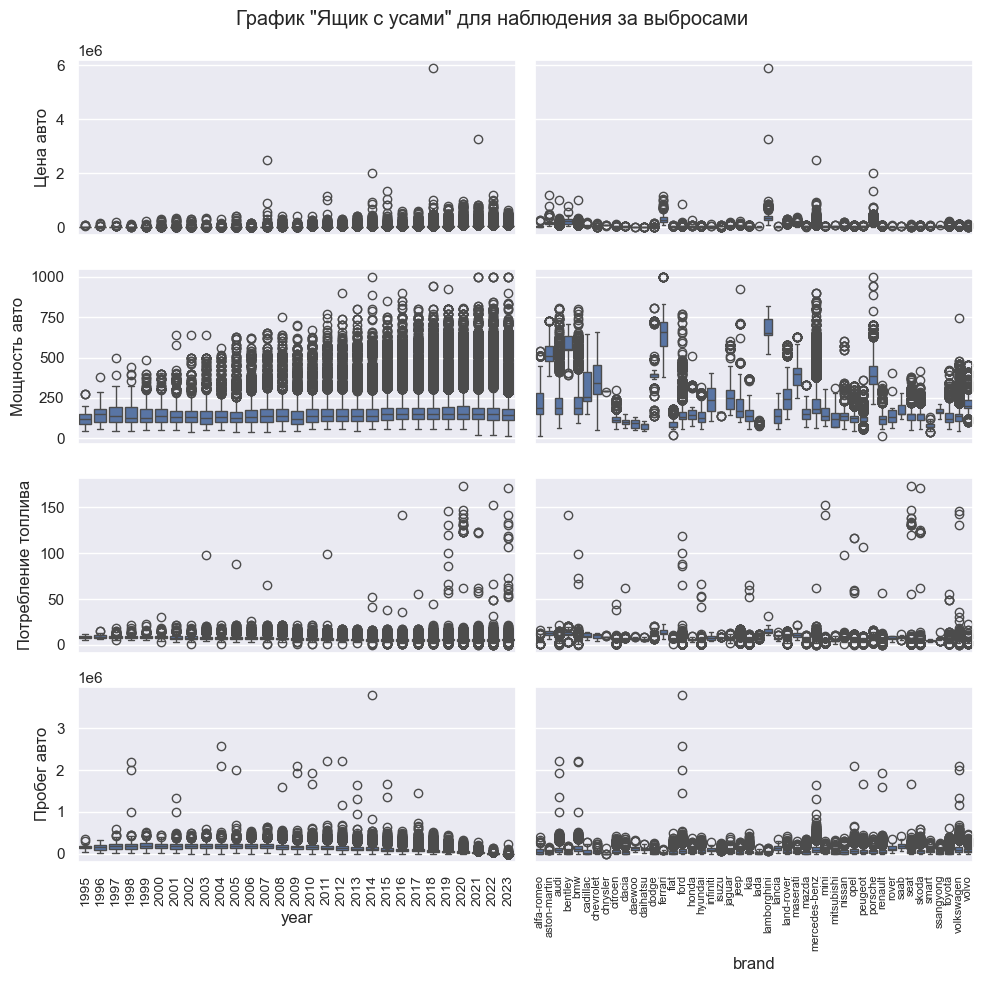

In [501]:
fig, ax = plt.subplots(4, 2, figsize = (10, 10), sharex = 'col', sharey = 'row', layout = 'tight')

fig.suptitle('График "Ящик с усами" для наблюдения за выбросами')

sns.boxplot(data = guc_edt_df, x = 'year', y = 'price_in_euro', ax = ax[0, 0])
sns.boxplot(data = guc_edt_df, x = 'year', y = 'power_ps', ax = ax[1, 0])
sns.boxplot(data = guc_edt_df, x = 'year', y = 'fuel_consumption_l_100km', ax = ax[2, 0])
sns.boxplot(data = guc_edt_df, x = 'year', y = 'mileage_in_km', ax = ax[3, 0])

sns.boxplot(data = guc_edt_df, x = 'brand', y = 'price_in_euro', ax = ax[0, 1])
sns.boxplot(data = guc_edt_df, x = 'brand', y = 'power_ps', ax = ax[1, 1])
sns.boxplot(data = guc_edt_df, x = 'brand', y = 'fuel_consumption_l_100km', ax = ax[2, 1])
sns.boxplot(data = guc_edt_df, x = 'brand', y = 'mileage_in_km', ax = ax[3, 1])

ax[0, 0].set_ylabel('Цена авто')
ax[1, 0].set_ylabel('Мощность авто')
ax[2, 0].set_ylabel('Потребление топлива')
ax[3, 0].set_ylabel('Пробег авто')

ax[3, 0].tick_params(axis = 'x', labelrotation = 90, labelsize = 'small')
ax[3, 1].tick_params(axis = 'x', labelrotation = 90, labelsize = 8)

plt.show()

<tr>Из графиков видно, что ярко выраженные выбросы  есть в атрибутах:
<li>- Цена авто;</li>
<li>- Потребление топлива;</li>
<li>- Пробег авто;</li>
</tr>
Попробуем разобраться, с чем связаны данные выбросы

***************

### 1. Построим графики взаимосвязи цены авто с другими атрибутами:

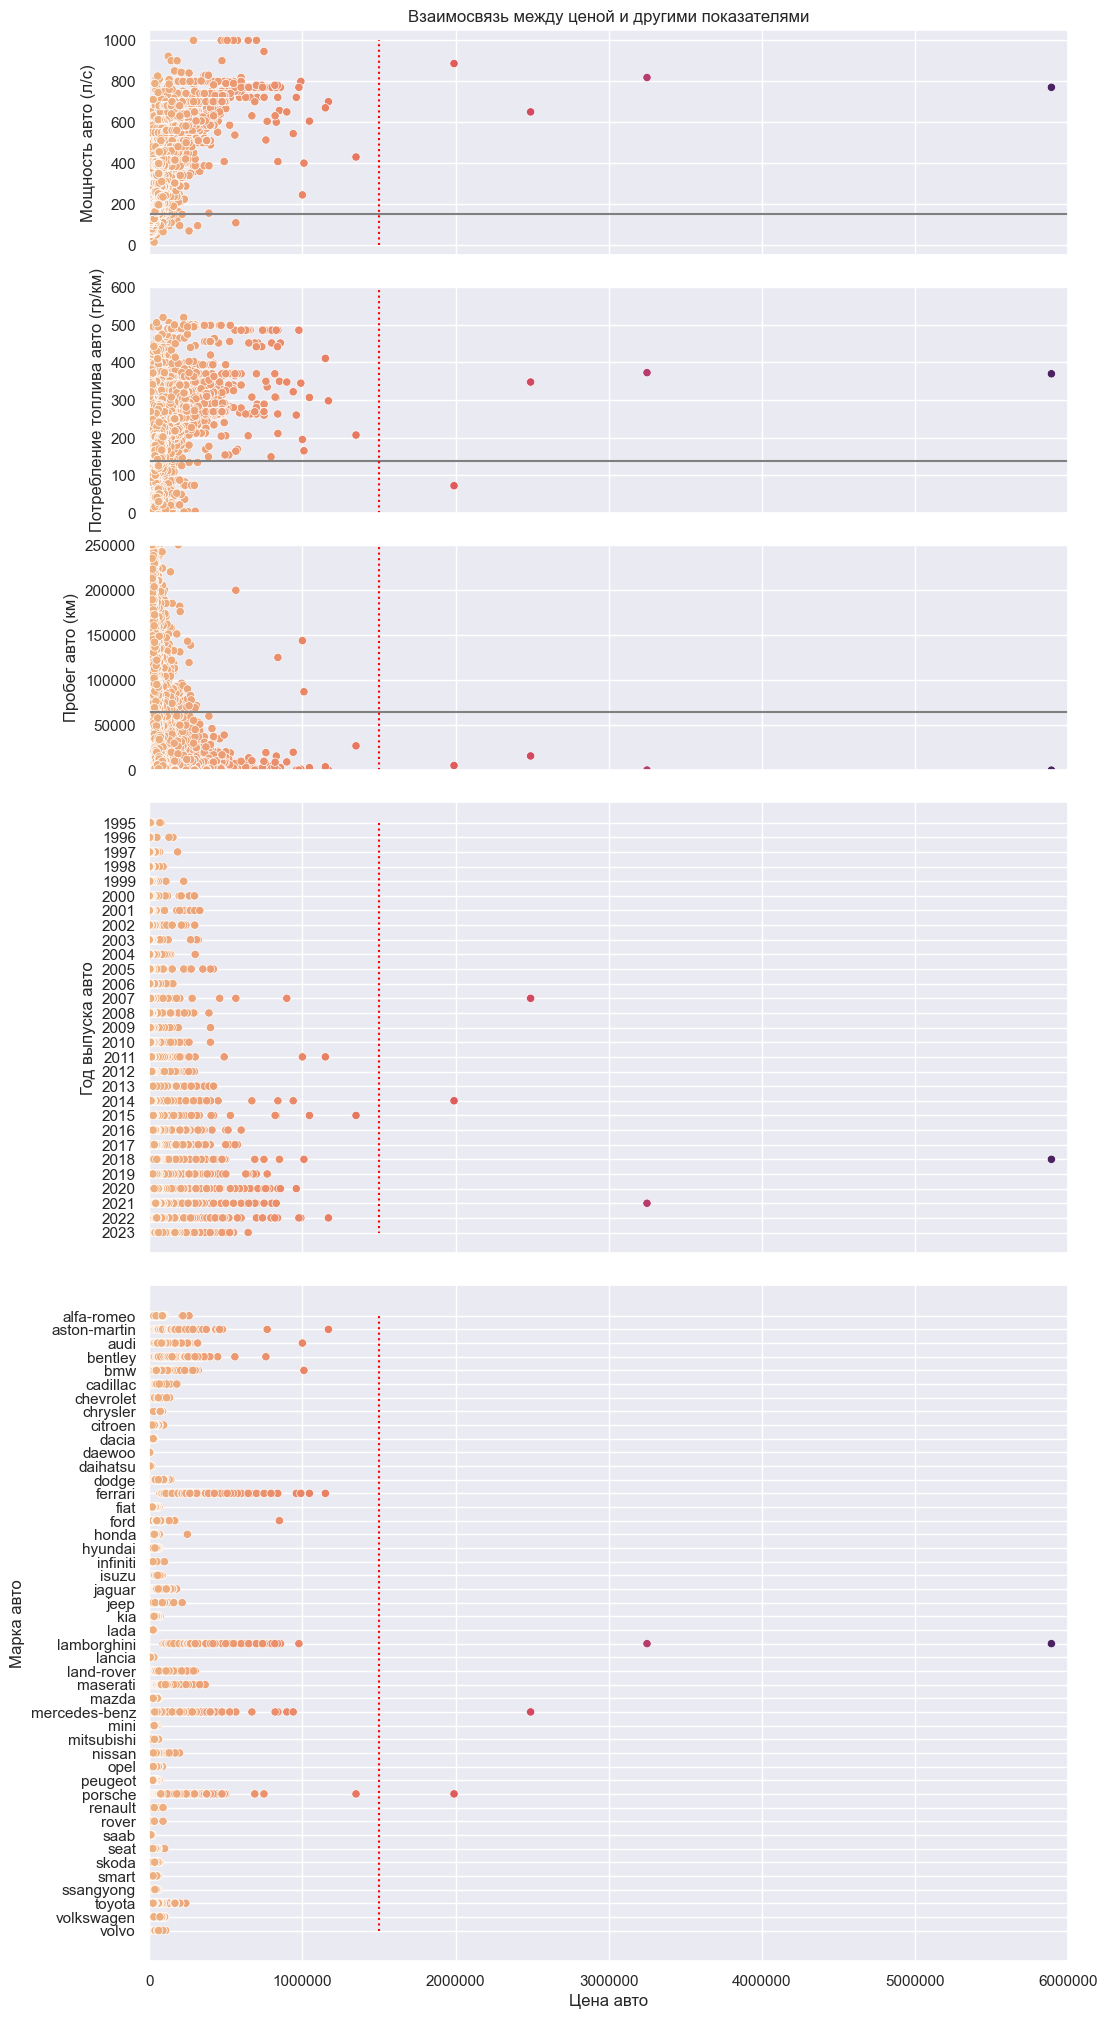

In [505]:
fig, ax = plt.subplots(5, 1, figsize = (10, 20), sharex = 'col', height_ratios = [1, 1, 1, 2, 3])
fig.tight_layout()
plot_scatter(ax = ax[0], 
             df = guc_edt_df, x = 'price_in_euro', y = 'power_ps',
             title = 'Взаимосвязь между ценой и другими показателями',
             ylabel = 'Мощность авто (л/с)',
             hue = 'price_in_euro', palette = 'flare',
             xmax = 6*10**6,
             x_vline = 1.5*10**6, line_ymin = 0, line_ymax = 1000,
             y_hline = 150, line_xmin = 0, line_xmax = 6*10**6
            )
plot_scatter(ax = ax[1], 
             df = guc_edt_df, x = 'price_in_euro', y = 'fuel_consumption_g_km',
             ylabel = 'Потребление топлива авто (гр/км)',
             ymax = 600,
             hue = 'price_in_euro', palette = 'flare',
             x_vline = 1.5*10**6, line_ymin = 0, line_ymax = 600,
             y_hline = 137, line_xmin = 0, line_xmax = 6*10**6
            )
plot_scatter(ax = ax[2], 
             df = guc_edt_df, x = 'price_in_euro', y = 'mileage_in_km',
             ylabel = 'Пробег авто (км)',
             ymax = 2.5*10**5,
             hue = 'price_in_euro', palette = 'flare',
             x_vline = 1.5*10**6, line_ymin = 0, line_ymax = 2.5*10**5,
             y_hline = 6.5*10**4, line_xmin = 0, line_xmax = 6*10**6
            )
plot_scatter(ax = ax[3], 
             df = guc_edt_df, x = 'price_in_euro', y = 'year',
             ylabel = 'Год выпуска авто',
             hue = 'price_in_euro', palette = 'flare',
             x_vline = 1.5*10**6, line_ymin = '1995', line_ymax = '2023'
            )
plot_scatter(ax = ax[4], 
             df = guc_edt_df, x = 'price_in_euro', y = 'brand',
             xlabel = 'Цена авто', ylabel = 'Марка авто',
             hue = 'price_in_euro', palette = 'flare',
             x_vline = 1.5*10**6, line_ymin = 'volvo', line_ymax = 'alfa-romeo'
            )
plt.show()

<i>
<tr>На графиках взаимосвязи значений:
<li>- красная вертикальная линия показывает границу, справа от которой присутствуют выбросы;</li>
<li>- серая горизонтальная линия показывает медианное значение признака;</li>
</i>

Видим, что правее линии цены 1,5 млн. евро присутствуют единичные выбросы, которые могут исказить данные.

<tr>Из графиков видно, что выбросы по цене дают авто, которые:
<li>- имеют достаточно мощный двигатель - более 600 лошадиных сил при среднем около 170;</li>    
<li>- расход топлива у авто марки Porsche при этом достаточно низкий (до 100 гр/км), у остальных высоки (от 300 до гр/км) при среднем в 150 гр/км;</li>
<li>- все авто с относительно малым пробегом и годом выпуска после 2007</li>
</tr>
Год выпуска кореллирует с пробегом, поэтому 2 последних графика можно оценивать в совокупности.<br/>
Из последнего графика видно, что все авто премиального сегмента. С учетом этого и предыдущих пунков складывается высокая цена.

***************

### 2. Построим на взаимосвязь количества потребляемого топлива с другими атрибутами:

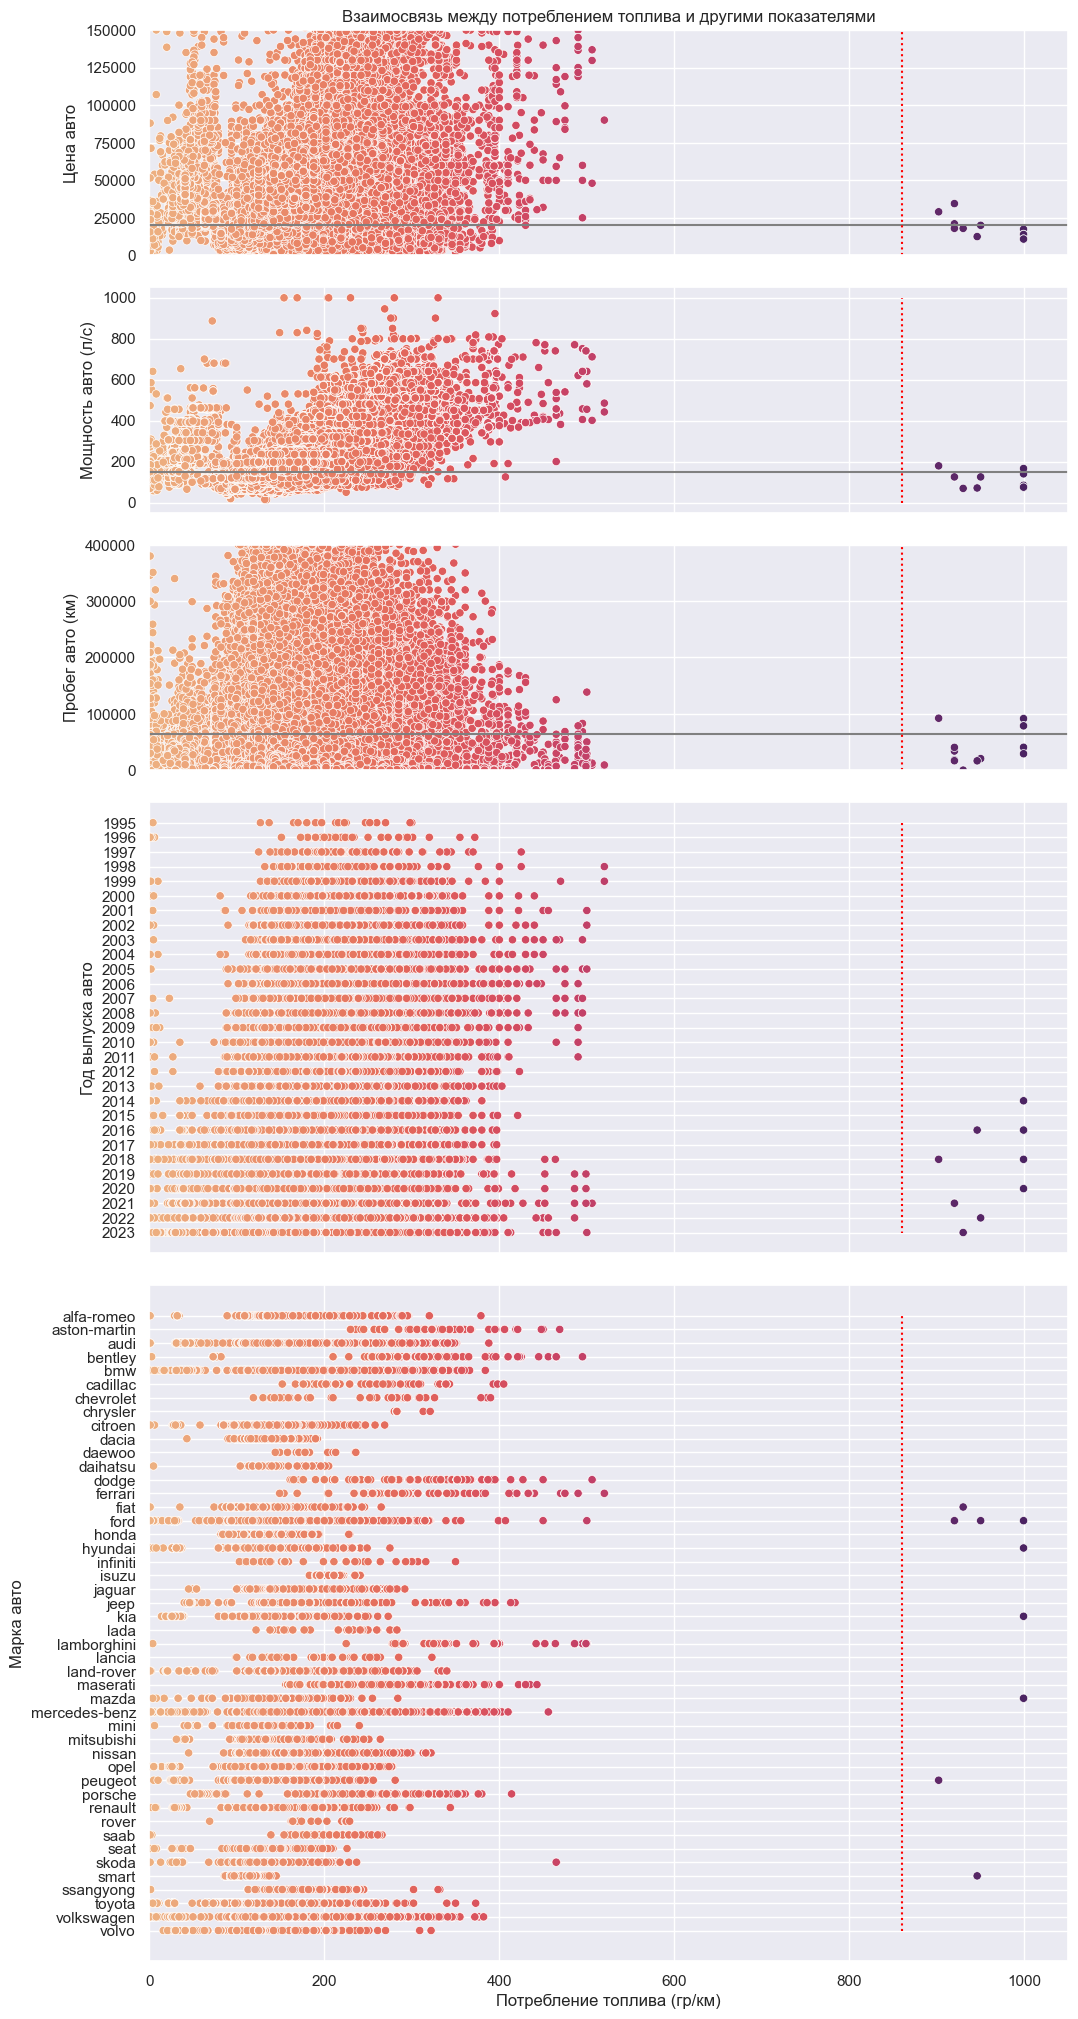

In [511]:
fig, ax = plt.subplots(5, 1, figsize = (10, 20), sharex = 'col', height_ratios = [1, 1, 1, 2, 3])
fig.tight_layout()
plot_scatter(ax = ax[0], 
             df = guc_edt_df, x = 'fuel_consumption_g_km', y = 'price_in_euro',
             title = 'Взаимосвязь между потреблением топлива и другими показателями',
             xmax = 1050, ymax = 1.5*10**5,
             ylabel = 'Цена авто',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 860, line_ymin = 0, line_ymax = 1.5*10**5,
             y_hline = 2*10**4, line_xmin = 0, line_xmax = 1050
            )
plot_scatter(ax = ax[1], 
             df = guc_edt_df, x = 'fuel_consumption_g_km', y = 'power_ps',
             ylabel = 'Мощность авто (л/с)',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 860, line_ymin = 0, line_ymax = 1000,
             y_hline = 150, line_xmin = 0, line_xmax = 1050
            )
plot_scatter(ax = ax[2], 
             df = guc_edt_df, x = 'fuel_consumption_g_km', y = 'mileage_in_km',
             ylabel = 'Пробег авто (км)',
             ymax = 4*10**5,
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 860, line_ymin = 0, line_ymax = 4*10**5,
             y_hline = 6.5*10**4, line_xmin = 0, line_xmax = 1050
            )
plot_scatter(ax = ax[3], 
             df = guc_edt_df, x = 'fuel_consumption_g_km', y = 'year',
             ylabel = 'Год выпуска авто',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 860, line_ymin = '1995', line_ymax = '2023'
            )
plot_scatter(ax = ax[4], 
             df = guc_edt_df, x = 'fuel_consumption_g_km', y = 'brand',
             xlabel = 'Потребление топлива (гр/км)', ylabel = 'Марка авто',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 860, line_ymin = 'volvo', line_ymax = 'alfa-romeo'
            )
plt.show()

Видно, что выбросы присутствуют после 860гр/км. При этом зависимые переменные находятся в районе медианных значений.

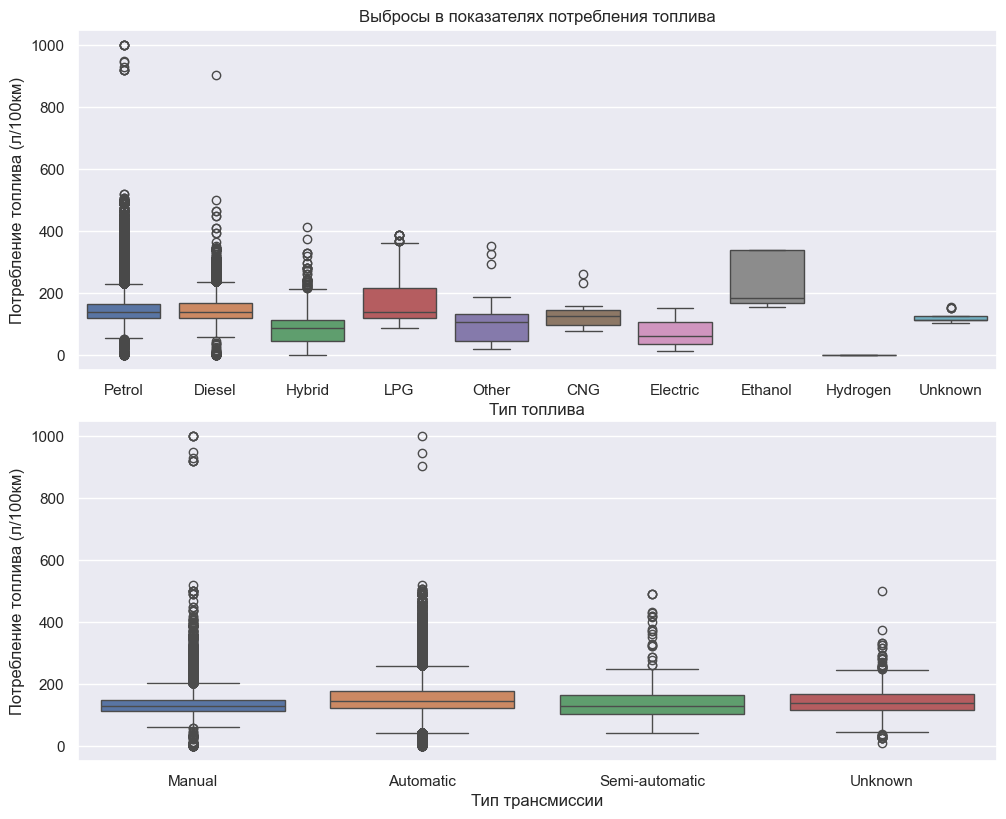

In [513]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
fig.tight_layout()
ax[0].set_title('Выбросы в показателях потребления топлива')
ax[0].set_xlabel('Тип топлива')
ax[0].set_ylabel('Потребление топлива (л/100км)')
ax[1].set_xlabel('Тип трансмиссии')
ax[1].set_ylabel('Потребление топлива (л/100км)')
sns.boxplot(data = guc_edt_df, x = 'fuel_type', y = 'fuel_consumption_g_km', hue = 'fuel_type', ax = ax[0])
sns.boxplot(data = guc_edt_df, x = 'transmission_type', y = 'fuel_consumption_g_km', hue = 'transmission_type', ax = ax[1])
plt.show()

Из графиков с усами выделить какой-либо один вид топлива или тип трансмиссии также нельзя. Выбросы присутствют в бензиновых и дизельных двигателях и в механике, и в автомате.

Т.о., объяснить данные выбросы можно только плохим качеством данных.

***************

### 3. Построим на взаимосвязь размера пробега авто с другими атрибутами:

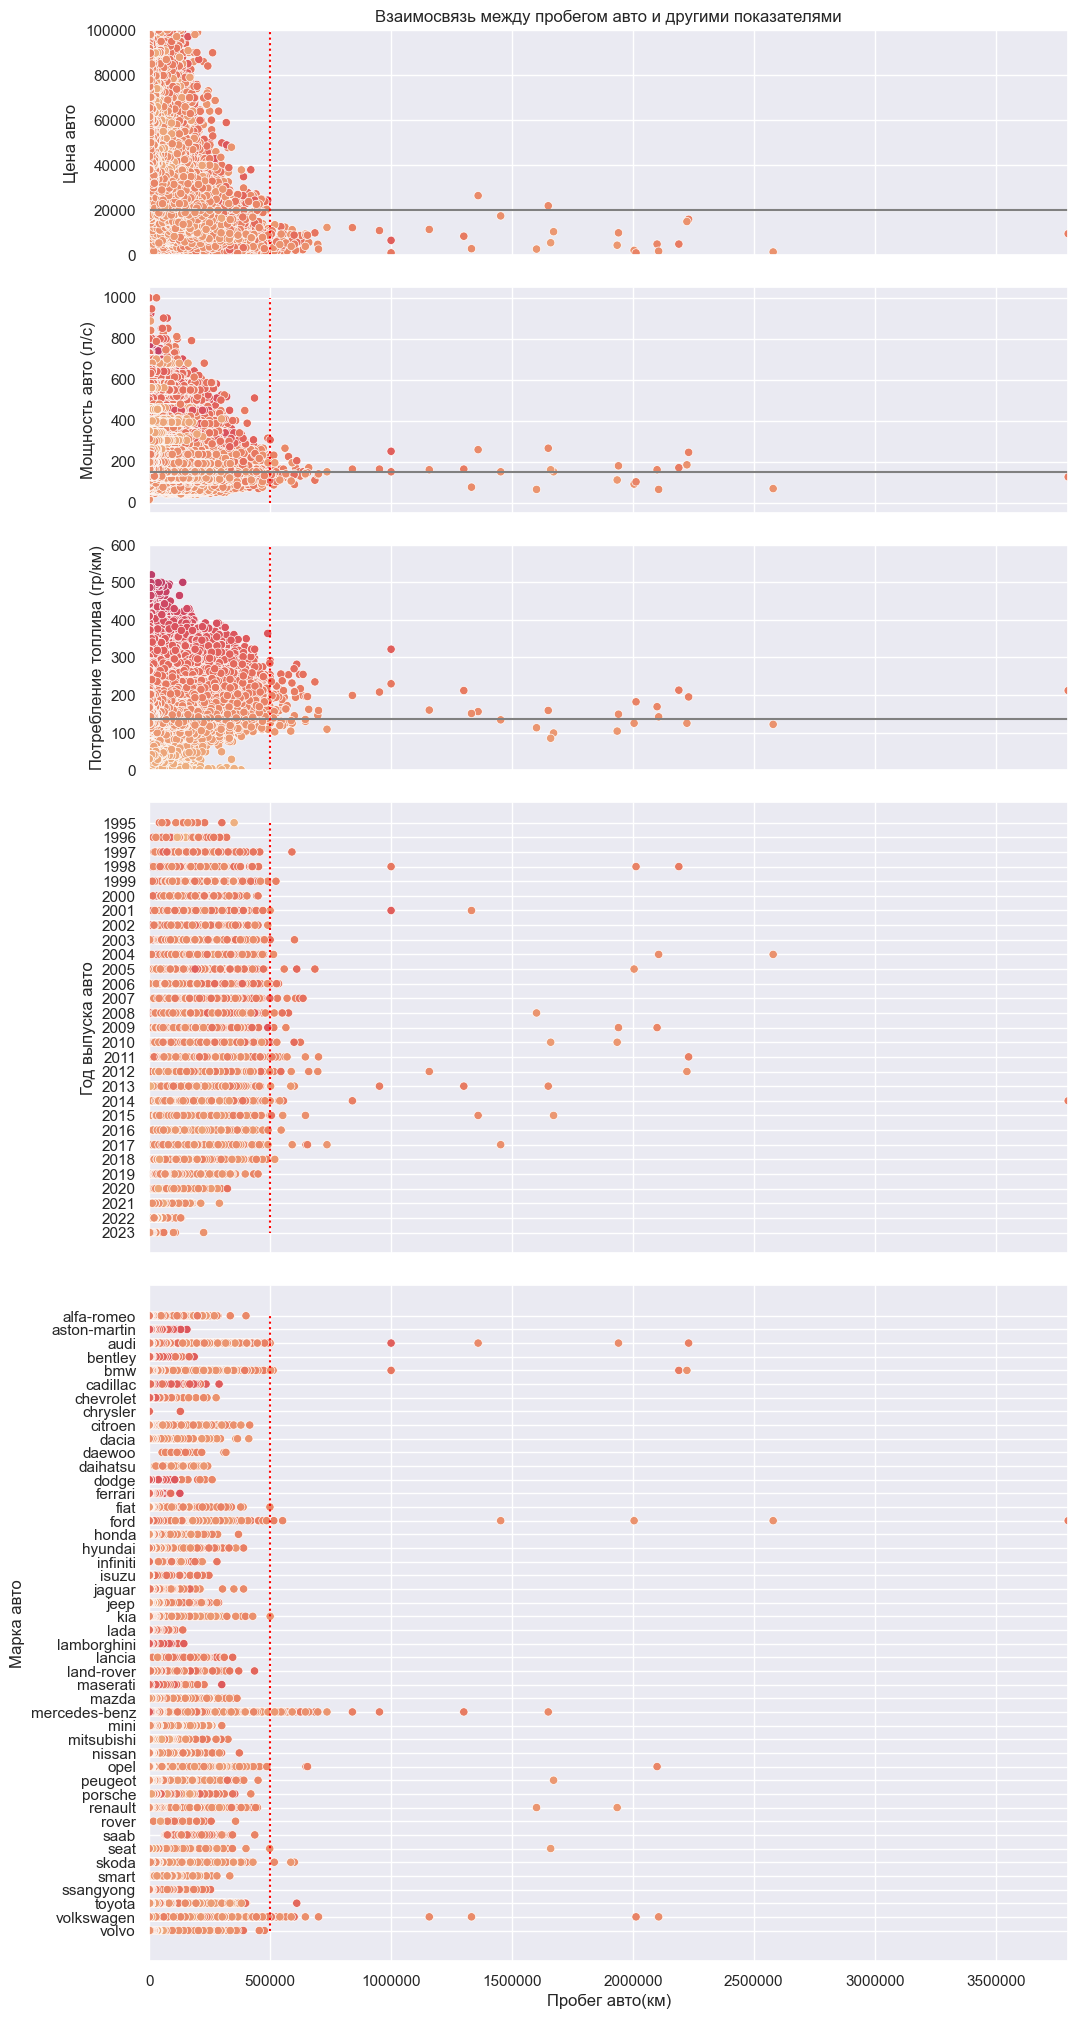

In [518]:
fig, ax = plt.subplots(5, 1, figsize = (10, 20), sharex = 'col', height_ratios = [1, 1, 1, 2, 3])
fig.tight_layout()
plot_scatter(ax = ax[0], 
             df = guc_edt_df, x = 'mileage_in_km', y = 'price_in_euro',
             title = 'Взаимосвязь между пробегом авто и другими показателями',
             xmax = 3.8*10**6, ymax = 10**5,
             ylabel = 'Цена авто',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 5*10**5, line_ymin = 0, line_ymax = 10**5,
             y_hline = 2*10**4, line_xmin = 0, line_xmax = 3.8*10**6
            )
plot_scatter(ax = ax[1], 
             df = guc_edt_df, x = 'mileage_in_km', y = 'power_ps',
             ylabel = 'Мощность авто (л/с)',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 5*10**5, line_ymin = 0, line_ymax = 1000,
             y_hline = 150, line_xmin = 0, line_xmax = 3.8*10**6
            )
plot_scatter(ax = ax[2], 
             df = guc_edt_df, x = 'mileage_in_km', y = 'fuel_consumption_g_km',
             ylabel = 'Потребление топлива (гр/км)',
             ymax = 600,
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 5*10**5, line_ymin = 0, line_ymax = 600,
             y_hline = 137, line_xmin = 0, line_xmax = 3.8*10**6
            )
plot_scatter(ax = ax[3], 
             df = guc_edt_df, x = 'mileage_in_km', y = 'year',
             ylabel = 'Год выпуска авто',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 5*10**5, line_ymin = '1995', line_ymax = '2023'
            )
plot_scatter(ax = ax[4], 
             df = guc_edt_df, x = 'mileage_in_km', y = 'brand',
             xlabel = 'Пробег авто(км)', ylabel = 'Марка авто',
             hue = 'fuel_consumption_g_km', palette = 'flare',
             x_vline = 5*10**5, line_ymin = 'volvo', line_ymax = 'alfa-romeo'
            )
plt.show()

По графикам пробега видно, что авто с выбросами в показателе, как правило дешевле, чем остальные. Также они старше 6ти лет. Остальные зависимые показатели в пределах средних значений.<br/>
Возможно, дынные авто покупаются на запчасти.

***************

## <u>Посмотрим на наличие пропусков в данных:</u>

In [522]:
nan_values = guc_edt_df.isna().sum()
nan_values[nan_values.values != 0]

color                        148
power_kw                      70
power_ps                      70
fuel_consumption_l_100km    2166
dtype: int64

Цвет авто не является показателем, достаточно полезным для расчета статистик. К тому же сложно определить, каким мог бы быть цвет, если он не заполнен в наборе данных.<br/>
Оставляем не заполнеными пустые значения по этому показателю.

Показатели мощности авто и потребление топлива тесно взаимосвязаны друг с другом. К тому же их можно определить по модели авто и году выпуска.

Посмотрим статистики по данным атрибутам до заполнения пропусков:

In [526]:
guc_edt_df.describe()[['power_kw', 'power_ps', 'fuel_consumption_l_100km']]

,power_kw,power_ps,fuel_consumption_l_100km
count,200250.00,200250.00,198154.00
mean,124.41,169.23,6.05
std,69.95,95.07,2.63
min,10.00,14.00,0.10
25%,81.00,110.00,4.90
50%,110.00,150.00,5.70
75%,140.00,190.00,6.70
max,735.00,999.00,173.00


Заполним пропуски самыми распространенными значениями по модели и году выпуска:

In [528]:
guc_edt_df['power_kw'] = guc_edt_df['power_kw']\
            .fillna(guc_edt_df.groupby(['model', 'year'])['power_kw'].transform(lambda x: x.mode()[0] if x.mode().size == 1 else None))
guc_edt_df['power_ps'] = guc_edt_df['power_ps']\
            .fillna(guc_edt_df.groupby(['model', 'year'])['power_ps'].transform(lambda x: x.mode()[0] if x.mode().size == 1 else None))
guc_edt_df['fuel_consumption_l_100km'] = guc_edt_df['fuel_consumption_l_100km']\
            .fillna(guc_edt_df.groupby(['model', 'year'])['fuel_consumption_l_100km'].transform(lambda x: x.mode()[0] if x.mode().size == 1 else None))

In [529]:
nan_values = guc_edt_df.isna().sum()
nan_values[nan_values.values != 0]

color                       148
power_kw                      5
power_ps                      5
fuel_consumption_l_100km    222
dtype: int64

Малая доля показателей, по которым нет данных в разрезе модели и года, все же остались не заполненными.

Посмотрим статистики по данным атрибутам после заполнения пропусков:

In [532]:
guc_edt_df.describe()[['power_kw', 'power_ps', 'fuel_consumption_l_100km']]

,power_kw,power_ps,fuel_consumption_l_100km
count,200315.00,200315.00,200098.00
mean,124.41,169.23,6.05
std,69.98,95.12,2.62
min,10.00,14.00,0.10
25%,81.00,110.00,4.90
50%,110.00,150.00,5.70
75%,140.00,190.00,6.70
max,735.00,999.00,173.00


Средние, медиана и другие статистики практически не изменились.

***************

## <u>Гипотезы:</u>

1. С годами доля продаж авто с АКПП растет и на данный момент превышает МКПП:

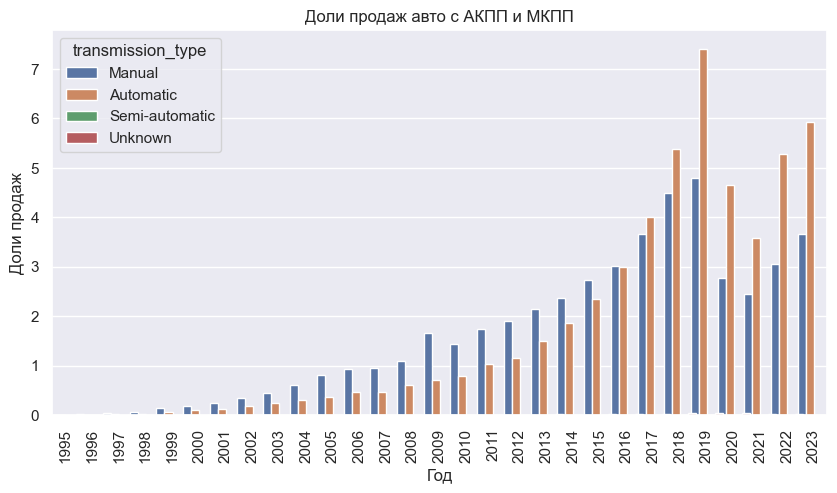

In [537]:
plt.figure(figsize = (10, 5))
plt.title('Доли продаж авто с АКПП и МКПП')
plt.xlabel('Год')
plt.ylabel('Доли продаж')
plt.xticks(rotation = 90)
sns.countplot(data = guc_edt_df, x = 'year', hue = 'transmission_type', stat = 'percent', width = 1.2)
plt.show()

2. Показатели стоимости и мощности авто на АКПП превышают аналогичные на МКПП:

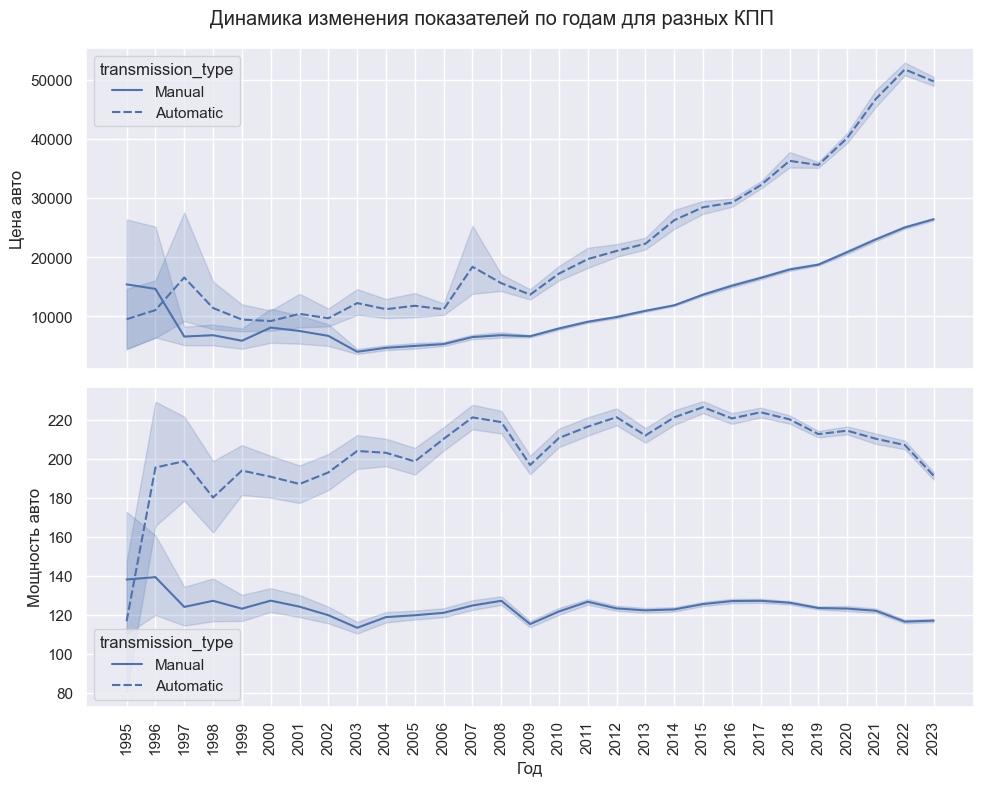

In [539]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8), sharex = 'col', layout = 'tight')
fig.suptitle('Динамика изменения показателей по годам для разных КПП')

df = guc_edt_df.loc[guc_edt_df['transmission_type'].isin(['Manual', 'Automatic']), ['year', 'transmission_type', 'price_in_euro']]
sns.lineplot(data = df, x = 'year', y = 'price_in_euro', style = 'transmission_type', estimator = 'mean', ax = ax[0])

df = guc_edt_df.loc[guc_edt_df['transmission_type'].isin(['Manual', 'Automatic']), ['year', 'transmission_type', 'power_ps']]
sns.lineplot(data = df, x = 'year', y = 'power_ps', style = 'transmission_type', estimator = 'mean', ax = ax[1])

ax[0].set_ylabel('Цена авто')
ax[1].set_ylabel('Мощность авто')
ax[1].set_xlabel('Год')
ax[1].tick_params(axis = 'x', rotation = 90)

plt.show()

3. Динамика роста цен на бензиновые и дизельные авто превышают рост цен на гибриды:

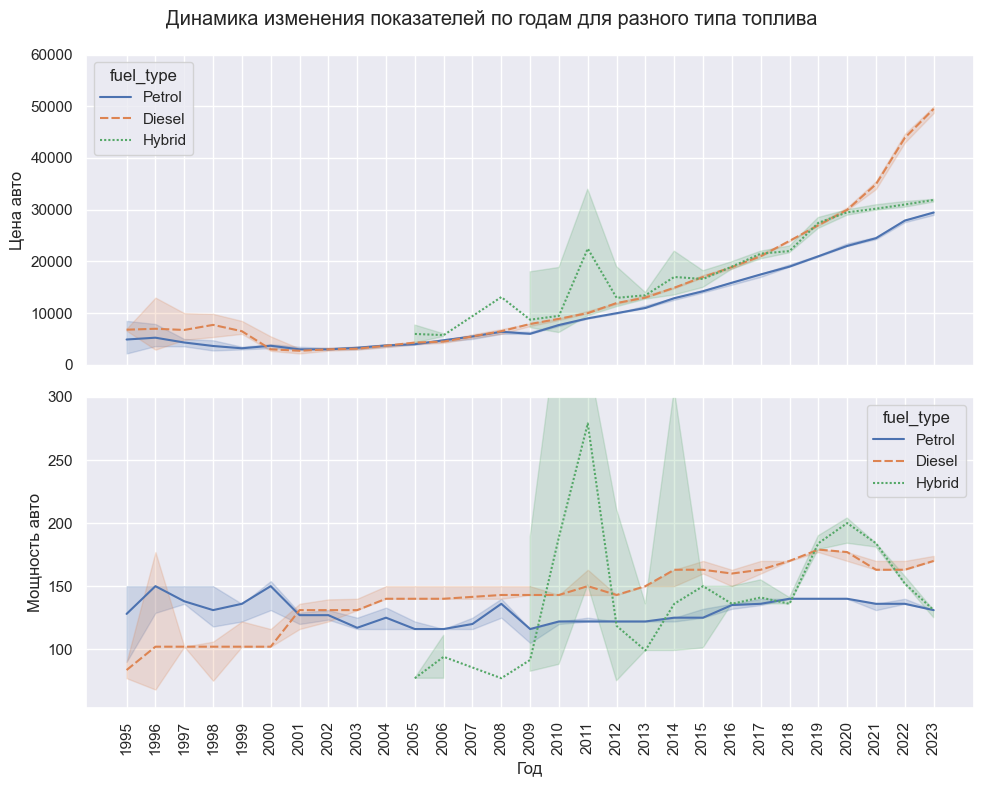

In [541]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8), sharex = 'col', layout = 'tight')
fig.suptitle('Динамика изменения показателей по годам для разного типа топлива')

df = guc_edt_df.loc[guc_edt_df['fuel_type'].isin(['Petrol', 'Diesel', 'Hybrid']), ['year', 'fuel_type', 'price_in_euro']]
sns.lineplot(data = df, x = 'year', y = 'price_in_euro', hue = 'fuel_type', style = 'fuel_type', estimator = 'median', ax = ax[0])
ax[0].set_ylim(top = 60000)

df = guc_edt_df.loc[guc_edt_df['fuel_type'].isin(['Petrol', 'Diesel', 'Hybrid']), ['year', 'fuel_type', 'power_ps']]
sns.lineplot(data = df, x = 'year', y = 'power_ps', hue = 'fuel_type', style = 'fuel_type', estimator = 'median', ax = ax[1])
ax[1].set_ylim(top = 300)

ax[0].set_ylabel('Цена авто')
ax[1].set_ylabel('Мощность авто')
ax[1].set_xlabel('Год')
ax[1].tick_params(axis = 'x', rotation = 90)

plt.show()

4. Авто с МКПП дешевле и более распространены, чем АКПП. При этом слегка проигрывают по мощности:

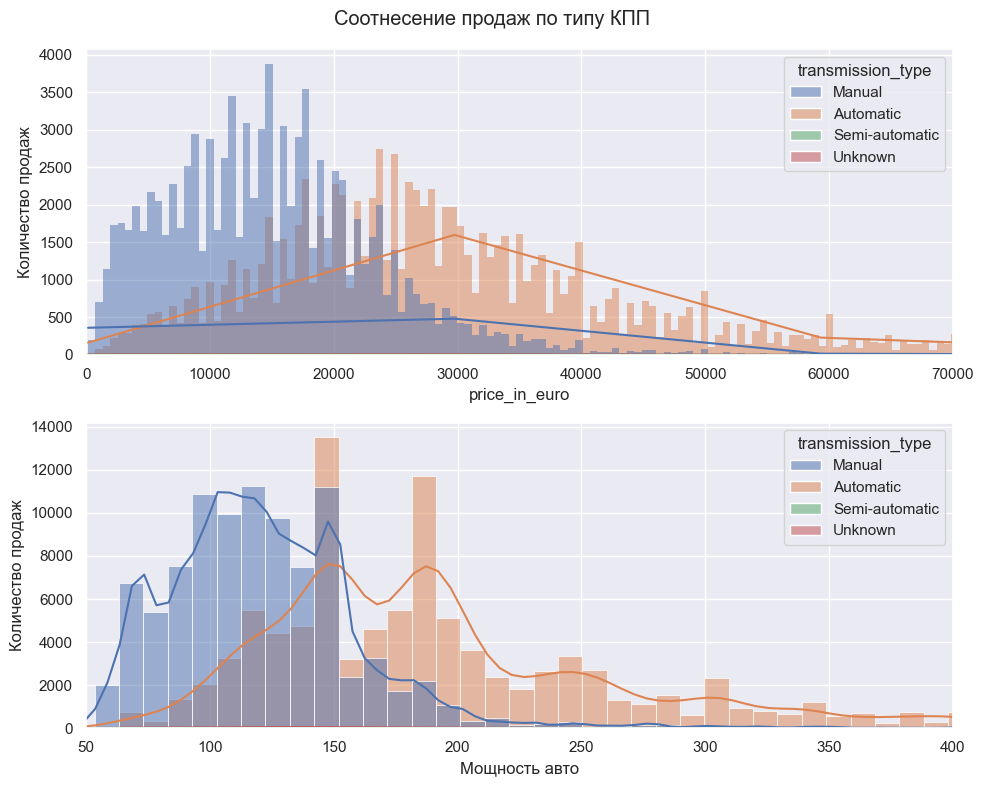

In [543]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8), layout = 'tight')
fig.suptitle('Соотнесение продаж по типу КПП')

sns.histplot(data = guc_edt_df, x = 'price_in_euro', hue = 'transmission_type', kde = True, ax = ax[0])
sns.histplot(data = guc_edt_df, x = 'power_ps', hue = 'transmission_type', kde = True, bins = 100, ax = ax[1])

ax[0].set_ylabel('Количество продаж')
ax[1].set_ylabel('Количество продаж')
ax[1].set_xlabel('Цена авто')
ax[1].set_xlabel('Мощность авто')
ax[0].set_xlim(0, 7*10**4)
ax[1].set_xlim(50, 400)

plt.show()